In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import json

# Построение шоков через труд

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


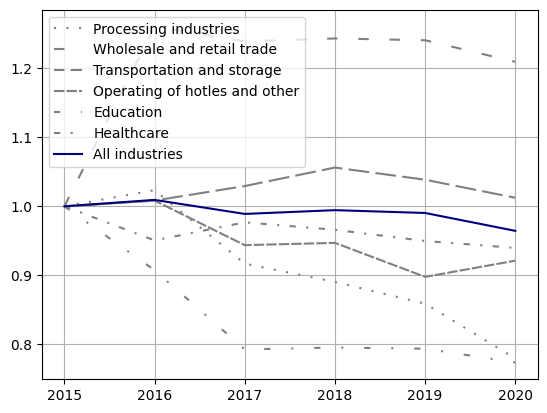

In [74]:
labels_list = [
    'Processing industries',
    'Wholesale and retail trade',
    'Transportation and storage',
    'Operating of hotles and other',
    'Education',
    'Healthcare'
]
idx_list = [2, 6, 7, 8, 11, 12]
style_list = [(0, (1, 5)), (0, (5, 10)), (5, (10, 3)),
              (0, (5, 1)), (0, (3, 10, 1, 10)), (0, (3, 5, 1, 5))]
for i in range(0, 6):
    res_i = []
    res_sum = []
    for j in range(0, 6):
        res_sum.append(L[j].sum(1)[76])
        res_i.append(L[j][76, i])
    plt.plot(np.arange(2015, 2021),
             np.array(res_i) / res_i[0],
             linestyle = style_list[i],
             label = labels_list[i],
             color='grey')
plt.plot(np.arange(2015, 2021),
         np.array(res_sum) / res_sum[0],
         label = 'All industries',
         color='navy')
plt.legend()
plt.grid()
plt.savefig('labour_dynamics.eps')

Что об этом можно сказать?
Можно сказать, что численность работников в отраслях в 2020 году по отношению к 2019 году уменьшилась незначительно

Можно посмотреть, насколько уменьшилось число людей в отраслях (слабо), так что серьезных шоков от этого быть не может, но мы проверим

Надо поискать информацию о локдаунах в новосибирске в 2020:
- здравоохранение должно вырасти
- услуги должны упасть
- транспорт должен упасть
- торговля может упасть
- образование
- обрабатывающие производства

In [85]:
def get_labour(year, df_labour_region, df_labour_branch):
    branch = np.array(df_labour_branch)[:, 1:]
    region = np.tile(df_labour_region.loc[:, year], (14, 1)).T
    return branch * region / 100

def get_shock_labour(idx_region: int, 
                     file_regions: str = '../data/raw_data/full_labour_regions.xlsx',
                     file_branches: str = '../data/raw_data/full_labour_branches.xlsx'):
    n_branches = 14
    n_years = 6
    
    start_year = 2015
    end_year = 2020
    
    df_labour_region = (
        pd.read_excel(file_regions)
        .rename({'Unnamed: 0': 'region'}, axis=1)
    )

    labour_branch = []
    for i in range(start_year, end_year+1):
        labour_branch.append(
            (
                pd.read_excel(file_branches, sheet_name=str(i))
                .rename({'Unnamed: 0': 'region'}, axis=1)
            )
        )

    L = []
    for i in np.arange(start_year, end_year+1):
        idx = i - start_year
        labour = get_labour(i, df_labour_region, labour_branch[idx])
        L.append(labour)
    
    L_time = []
    for i in range(0, n_branches):
        res_i = []
        for j in range(0, n_years):
            res_i.append(L[j][idx_region, i])
        L_time.append(res_i)
    L_time = np.array(L_time)
    
    t = np.arange(start_year, end_year)
    alpha = 0.3
    weights = np.exp(alpha*t) / np.exp(alpha*t).sum()
    norm_past = np.array(L_time[:, :-1] * np.tile(weights, (n_branches, 1))).sum(1)
    
    return L[-1][idx_region, :] / norm_past

# Оценка шоков и использованием ВВП

In [51]:
def get_shock_vvp(idx_region, df_vvp, df_labour):
    coef_reg = list(df_labour.loc[idx_region])[1:] / \
               np.array(list(df_labour.loc[idx_region])[1:]).sum()
    coef_rf = list(df_labour.loc[0])[1:] / \
              np.array(list(df_labour.loc[0])[1:]).sum()
    return ((df_vvp.Proc - 100)[:14] * coef_reg / coef_rf + 100) / 100

# Сохранение

In [121]:
f = open('../data/algo_data/branch_names_eng.json')
names = json.load(f)
f.close()

df_shocks = pd.DataFrame({})
df_shocks.insert(0, 'Branches', names)
df_shocks = df_shocks.set_index('Branches')
df_shocks

""
Branches
"Agriculture, forestry"
Mining
Processing industries
Electric power supply and other
"Water supply, sanitation and other"
Construction
Wholesale and retail trade
Transportation and storage
Operation of hotels and other


In [126]:
idx_region = 76 # novosib
idx_region = 77 # omsk
idx_region = 10 # lipezk
idx_region = 27 # murmansk
idx_region = 38 # rostov

shock_vvp = get_shock_vvp(idx_region, df_vvp, df_labour)
shock_labour = get_shock_labour(idx_region)

df_shocks.insert(0, 'labour_'+str(idx_region), shock_labour)
df_shocks.insert(1, 'vvp_'+str(idx_region), list(shock_vvp))


In [127]:
df_shocks.to_excel('../data/data_for_analysis/df_shocks_2019.xlsx')

/tmp/ipykernel_827457/768022422.py:1: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.2.9' currently installed).
  df_shocks.to_excel('../data/data_for_analysis/df_shocks_2019.xlsx')


# 